# Kitas Hamburg
 Idea is from [https://juanitorduz.github.io/kitas_berlin/](https://juanitorduz.github.io/kitas_berlin/)

Recommended: [check this out](https://juanitorduz.github.io/germany_plots/) for plotting plz data with [geopandas](https://geopandas.org/index.html): 


## Get Data for plz-Codes and Hamburger Kitas
one data source for this post is [www.suche-postleitzahl.org/downloads](www.suche-postleitzahl.org/downloads). Here we download three data sets:

+ `plz-gebiete.shp`: shapefile with germany postal codes polygons.
+ `zuordnung_plz_ort.csv`: postal code to city and bundesland mapping.
+ `plz_einwohner.csv`: population is assigned to each postal code area.

## prepare notebook

Found some data for [Hamburger Kitas](https://suche.transparenz.hamburg.de/dataset/kita-einrichtungen-hamburg14?forceWeb=true). Download csv file.

Still missing the count of `spots` per Kita, `type` and `carrier_type`.

Need scraper for [suche-kita](https://www.suche-kita.de/kitaplätze/) ...



In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import mplleaflet
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

Loading csv file from data folder.

In [7]:
kitas_raw_df = pd.read_csv('data/plz/Kita_Einrichtung.csv', delimiter='^',header=1,
    dtype={'KITAEinrichtung_PLZ': str}
)

In [8]:
kitas_raw_df.head()

,KITAEinrichtung_EinrNr,KITAEinrichtung_Name,KITAEinrichtung_Strasse,KITAEinrichtung_HausNr,KITAEinrichtung_HausNr_Alpha,KITAEinrichtung_PLZ,KITAEinrichtung_Ort,Stadtteil_Name,KITABezirk_Name,KITAEinrichtung_AnsprechPartner,KITAEinrichtung_Telefon,KITAEinrichtung_Fax,KITATraeger_Name,KITAEr_refs_URL,KITAEr_refs_Email
0,1009889,Ev. KiTa der Hauptkirche St. Petri,Bei der Petrikirche,3,a,20095,Hamburg,Hamburg-Altstadt,Hamburg-Mitte,Frau Halmschlag,188 88 66,18 88 86 88,Kirchengemeindeverband der Kindertageseinricht...,NaN,Kita@sankt-petri.de
1,1009890,Ev. KiTa St. Michaelis,Gerstäckerstraße,5,NaN,20459,Hamburg,Neustadt,Hamburg-Mitte,Frau Gadhof,36 80 17 84,36 80 17 85,Kirchengemeindeverband der Kindertageseinricht...,NaN,kita@st-michaelis.de
2,1009891,KiTa Markusstraße,Markusstraße,10,NaN,20355,Hamburg,Neustadt,Hamburg-Mitte,Frau Alexewicz,34 60 24,35 71 17 11,Elbkinder Vereinigung Hamburger Kitas gGmbH,www.elbkinder-kita.de/kita-markusstrasse,kita-markusstrasse@elbkinder-kitas.de
3,1009892,KiTa Murmel,Jungiusstraße,3,NaN,20355,Hamburg,Neustadt,Hamburg-Mitte,Frau Heike Wöste,35 42 89,NaN,Kinderladen Murmel e.V.,www.kinderladen-murmel.de,die-murmeln@gmx.de
4,1009893,KiTa Kohlhöfen,Kohlhöfen,22,NaN,20355,Hamburg,Neustadt,Hamburg-Mitte,Frau Plegge,34 28 77,35 71 23 29,Elbkinder Vereinigung Hamburger Kitas gGmbH,www.elbkinder-kitas.de/kita-kohlhoefen,kita-kohlhoefen@elbkinder-kitas.de


In [9]:
kitas_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   KITAEinrichtung_EinrNr           1144 non-null   int64 
 1   KITAEinrichtung_Name             1144 non-null   object
 2   KITAEinrichtung_Strasse          1144 non-null   object
 3   KITAEinrichtung_HausNr           1144 non-null   int64 
 4   KITAEinrichtung_HausNr_Alpha     175 non-null    object
 5   KITAEinrichtung_PLZ              1144 non-null   object
 6   KITAEinrichtung_Ort              1144 non-null   object
 7   Stadtteil_Name                   1144 non-null   object
 8   KITABezirk_Name                  1144 non-null   object
 9   KITAEinrichtung_AnsprechPartner  1116 non-null   object
 10  KITAEinrichtung_Telefon          1091 non-null   object
 11  KITAEinrichtung_Fax              582 non-null    object
 12  KITATraeger_Name                 1

## Format Data

Next, we format the data and prepare it for the analysis.

In [26]:
# We verify there is just one city.
kitas_raw_df['KITAEinrichtung_Ort'].unique()

array(['Hamburg'], dtype=object)

In [23]:
# Ort capitalized und upper
#kitas_raw_df['KITAEinrichtung_Ort'] = kitas_raw_df['KITAEinrichtung_Ort'].str.lower()
#kitas_raw_df['KITAEinrichtung_Ort'] = kitas_raw_df['KITAEinrichtung_Ort'].str.capitalize()

In [27]:
kitas_raw_df.head()

,KITAEinrichtung_EinrNr,KITAEinrichtung_Name,KITAEinrichtung_Strasse,KITAEinrichtung_HausNr,KITAEinrichtung_HausNr_Alpha,KITAEinrichtung_PLZ,KITAEinrichtung_Ort,Stadtteil_Name,KITABezirk_Name,KITAEinrichtung_AnsprechPartner,KITAEinrichtung_Telefon,KITAEinrichtung_Fax,KITATraeger_Name,KITAEr_refs_URL,KITAEr_refs_Email
0,1009889,Ev. KiTa der Hauptkirche St. Petri,Bei der Petrikirche,3,a,20095,Hamburg,Hamburg-Altstadt,Hamburg-Mitte,Frau Halmschlag,188 88 66,18 88 86 88,Kirchengemeindeverband der Kindertageseinricht...,NaN,Kita@sankt-petri.de
1,1009890,Ev. KiTa St. Michaelis,Gerstäckerstraße,5,NaN,20459,Hamburg,Neustadt,Hamburg-Mitte,Frau Gadhof,36 80 17 84,36 80 17 85,Kirchengemeindeverband der Kindertageseinricht...,NaN,kita@st-michaelis.de
2,1009891,KiTa Markusstraße,Markusstraße,10,NaN,20355,Hamburg,Neustadt,Hamburg-Mitte,Frau Alexewicz,34 60 24,35 71 17 11,Elbkinder Vereinigung Hamburger Kitas gGmbH,www.elbkinder-kita.de/kita-markusstrasse,kita-markusstrasse@elbkinder-kitas.de
3,1009892,KiTa Murmel,Jungiusstraße,3,NaN,20355,Hamburg,Neustadt,Hamburg-Mitte,Frau Heike Wöste,35 42 89,NaN,Kinderladen Murmel e.V.,www.kinderladen-murmel.de,die-murmeln@gmx.de
4,1009893,KiTa Kohlhöfen,Kohlhöfen,22,NaN,20355,Hamburg,Neustadt,Hamburg-Mitte,Frau Plegge,34 28 77,35 71 23 29,Elbkinder Vereinigung Hamburger Kitas gGmbH,www.elbkinder-kitas.de/kita-kohlhoefen,kita-kohlhoefen@elbkinder-kitas.de


In [28]:
# Rename columns from German to English.
rename_cols = {
    'KITABezirk_Name': 'district',
    'Stadtteil_Name': 'borough',
    'KITAEinrichtung_EinrNr': 'id',
    'KITAEinrichtung_Name': 'name',
    'KITAEinrichtung_Strasse': 'street',
    'KITAEinrichtung_HausNr': 'house_no',
    'KITAEinrichtung_HausNr_Alpha': 'house_no_letter',
    'KITAEinrichtung_PLZ': 'plz',                  
    'KITAEinrichtung_AnsprechPartner': 'contact',                  
    'KITAEinrichtung_Telefon': 'telephone',       
    'KITAEinrichtung_Fax': 'fax',       
#    'Anzahl Plätze': 'spots'  , #find data
#    'Einrichtungsart': 'type',
#    'Trägernummer': 'carrier_number',
    'KITATraeger_Name': 'carrier_name',  
    'KITAEr_refs_URL': 'url',  
    'KITAEr_refs_Email': 'eMail',  
#    'Trägerart': 'carrier_type',
}

columns_to_drop = [ 
    'KITAEinrichtung_Ort',
]

# Format data: remove redundant columns, rename columns and add new features.
kitas_df = kitas_raw_df \
    .copy() \
    .drop(columns_to_drop, axis=1) \
    .rename(columns=rename_cols) \
    .assign(
        num_kitas_plz=lambda x: x.groupby(['district', 'plz'])['id'].transform('count'),
#        spots_plz=lambda x: x.groupby(['district', 'plz'])['spots'].transform(np.sum)
    )
    
kitas_df.head()

,id,name,street,house_no,house_no_letter,plz,borough,district,contact,telephone,fax,carrier_name,url,eMail,num_kitas_plz
0,1009889,Ev. KiTa der Hauptkirche St. Petri,Bei der Petrikirche,3,a,20095,Hamburg-Altstadt,Hamburg-Mitte,Frau Halmschlag,188 88 66,18 88 86 88,Kirchengemeindeverband der Kindertageseinricht...,NaN,Kita@sankt-petri.de,1
1,1009890,Ev. KiTa St. Michaelis,Gerstäckerstraße,5,NaN,20459,Neustadt,Hamburg-Mitte,Frau Gadhof,36 80 17 84,36 80 17 85,Kirchengemeindeverband der Kindertageseinricht...,NaN,kita@st-michaelis.de,4
2,1009891,KiTa Markusstraße,Markusstraße,10,NaN,20355,Neustadt,Hamburg-Mitte,Frau Alexewicz,34 60 24,35 71 17 11,Elbkinder Vereinigung Hamburger Kitas gGmbH,www.elbkinder-kita.de/kita-markusstrasse,kita-markusstrasse@elbkinder-kitas.de,6
3,1009892,KiTa Murmel,Jungiusstraße,3,NaN,20355,Neustadt,Hamburg-Mitte,Frau Heike Wöste,35 42 89,NaN,Kinderladen Murmel e.V.,www.kinderladen-murmel.de,die-murmeln@gmx.de,6
4,1009893,KiTa Kohlhöfen,Kohlhöfen,22,NaN,20355,Neustadt,Hamburg-Mitte,Frau Plegge,34 28 77,35 71 23 29,Elbkinder Vereinigung Hamburger Kitas gGmbH,www.elbkinder-kitas.de/kita-kohlhoefen,kita-kohlhoefen@elbkinder-kitas.de,6


## EDA

number of unique values per feature

In [30]:
kitas_df.apply(lambda x: x.unique().size, axis=0)

id                 1144
name               1107
street              872
house_no            215
house_no_letter      10
plz                 100
borough              92
district              7
contact            1013
telephone          1073
fax                 580
carrier_name        514
url                 410
eMail              1080
num_kitas_plz        24
dtype: int64

In [31]:
# Dimensions data set.
kitas_df.shape

(1144, 15)

We have 1144 Kitas in our data set and the id column is indeed an unique identifier of each Kita. The name, on the other hand, is not.

In [35]:
kitas_df \
    .groupby(['name']) \
    .agg(num_kitas=('id', 'count')) \
    .query('num_kitas > 1') \
    .sort_values('num_kitas', ascending=False) \
    .head()

,num_kitas
name,
KiTa Käptn Kaninchen,7
KiTa Sonnenschein,3
KiTa Apoidea favo bambini,3
KiTa Pünktchens Tintenklecks,3
KiTa Frosch,3


## Kitas per District

We start by looking into the first layer of geo-location granularity: district (there are 7 districts in Hamburg).

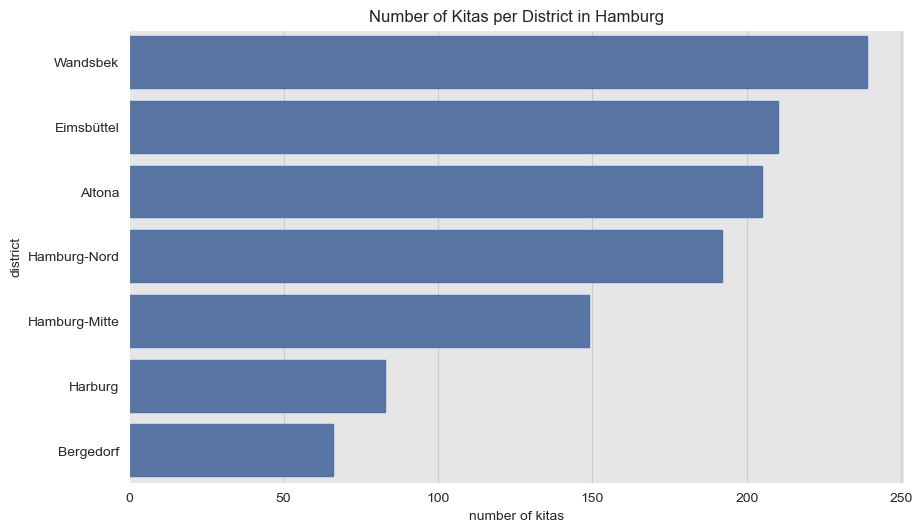

In [36]:
fig, ax = plt.subplots()
kitas_df \
    .groupby(['district']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='n', 
        y='district',
        color=sns_c[0],
        edgecolor=sns_c[0],
        ax=ax
    )
ax.set(
    title='Number of Kitas per District in Hamburg', 
    xlabel='number of kitas', 
    ylabel='district'
);

We generate the same plot but showing the shares instead.

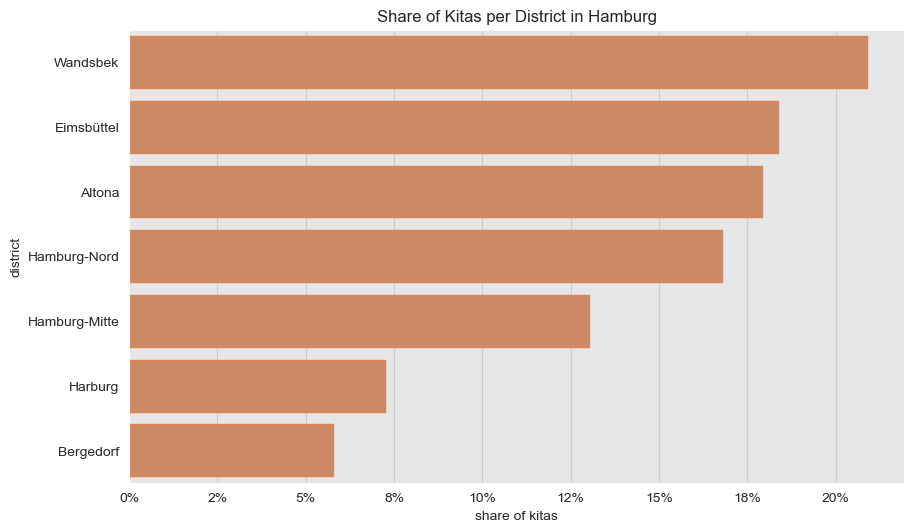

In [37]:
fig, ax = plt.subplots()
kitas_df \
    .groupby(['district']) \
    .agg(n=('id', 'count')) \
    .assign(share= lambda x: x['n'] / x['n'].sum()) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='share', 
        y='district',
        color=sns_c[1],
        edgecolor=sns_c[1],
        ax=ax
    )
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:0.0%}'.format(y)))
ax.set(
    title='Share of Kitas per District in Hamburg', 
    xlabel='share of kitas', 
    ylabel='district'
);

Wandsbek? is a rather big district compared to Mitte ? area-wise. In order to run a fair comparison across districts, we need to control by size or population (which we will do bellow).

## Kitas per PLZ

Now we dig deeper into plz level. A natural question is: How many Kitas each plz has? To answer it let us look into the distribution (again, in order to make a fair comparison we need to control by plz population or size).

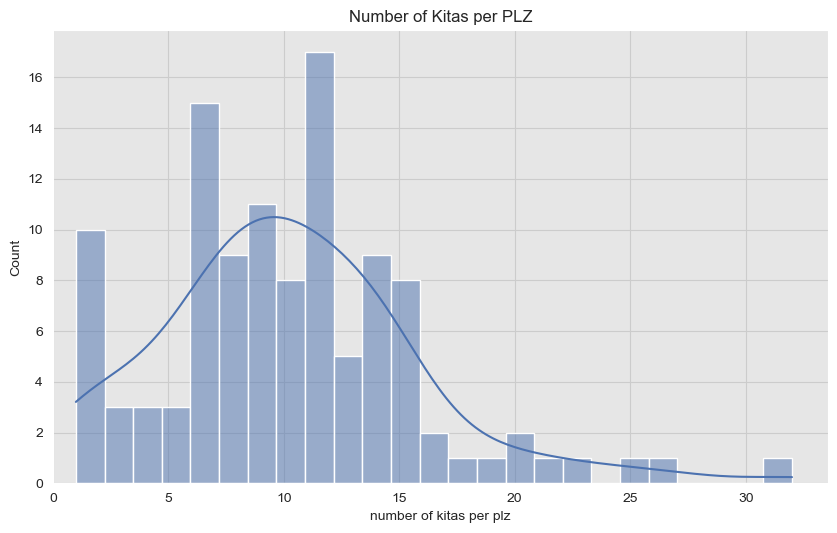

In [38]:
fig, ax = plt.subplots()
kitas_df \
    .groupby(['district', 'plz']) \
    .agg(n=('name', 'count')) \
    .pipe((sns.histplot, 'data'),
        x='n', 
        bins=25, 
        kde=True,
        ax=ax
    )
ax.set(
    title='Number of Kitas per PLZ', 
     xlabel='number of kitas per plz',
     xlim=(0, None)
);

We see there is a long tail. Let us see the plz with more Kitas:

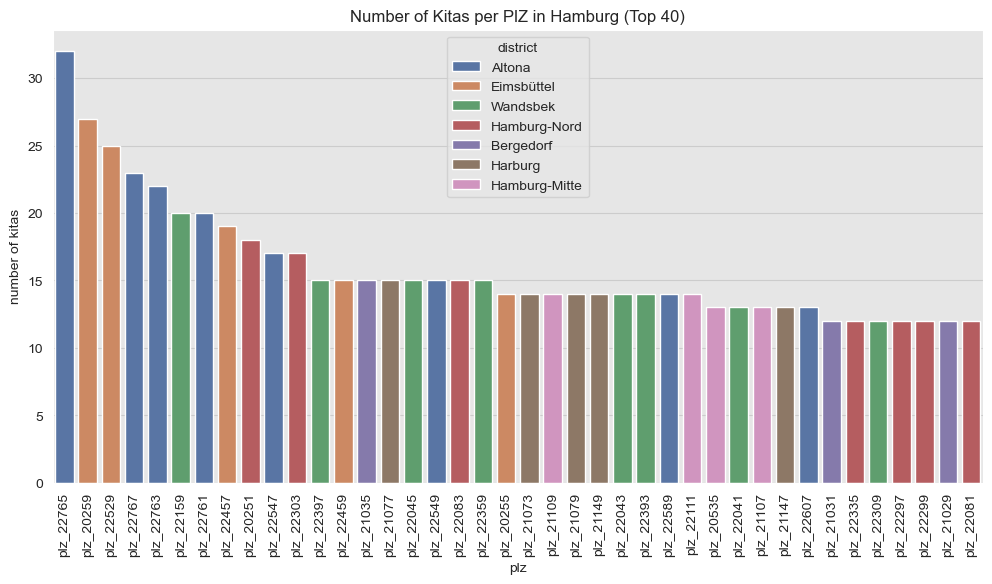

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
kitas_df \
    .groupby(['district', 'plz']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .assign(plz = lambda x: 'plz_' + x['plz']) \
    .sort_values('n', ascending=False) \
    .head(40) \
    .pipe((sns.barplot, 'data'),  
        x='plz',
        y='n',
        hue='district',
        dodge=False,
        ax=ax
    )
ax.tick_params(axis='x', labelrotation=90)
ax.set(
    title='Number of Kitas per PlZ in Hamburg (Top 40)', 
     xlabel='plz', 
     ylabel='number of kitas', 
);

Altona is a very trendy area in Hamburg, specially for young families.

Next, let us plot the distribution of the number of Kitas per plz split by district.

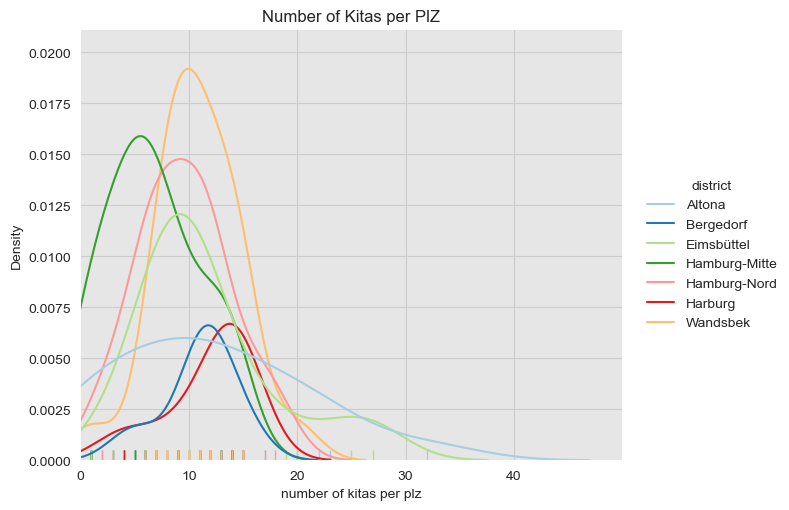

In [40]:
g = kitas_df \
    .groupby(['district', 'plz']) \
    .agg(n=('name', 'count')) \
    .pipe((sns.displot, 'data'), 
        x='n',
        hue='district',
        kind='kde',
        rug=True, 
        height=5,
        aspect=1.3,
        palette='Paired'
    )
ax = g.axes.flatten()[0]
ax.set(
    title='Number of Kitas per PlZ', 
     xlabel='number of kitas per plz',
     xlim=(0, None)
);

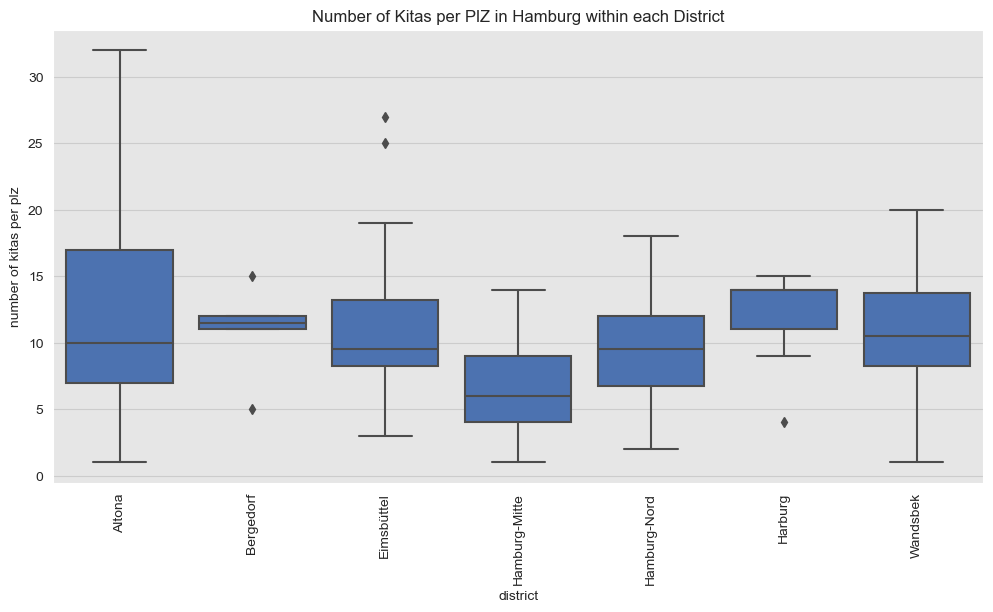

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
kitas_df \
    .groupby(['district', 'plz']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .sort_values('district') \
    .pipe((sns.boxplot, 'data'), 
        x='district', 
        y='n',
        color=sns_c[0],
        saturation=1.0,
        ax=ax
    )
ax.tick_params(axis='x', labelrotation=90)
ax.set(
    title='Number of Kitas per PlZ in Hamburg within each District', 
     ylabel='number of kitas per plz', 
);

It seems that, on average, Bergedorf has most Kitas per plz and Altona has the highest variance (again, we need to control by plz size to be more precise).

## Spots per Kita

Analysis not possible, due to lack of data.

## Carriers

Now we want to investigate the carriers coverage on the number of kitas. The questions we want to answer are:

1. Do carriers with more than one Kita dominate the Kita distribution?

2. Do we see a difference across districts?

To answer both question we need to compute how many Kitas each carrier has. In addition,we sort them out by the number of Kitas calculate the (cumulative) share on the number of Kitas. This will allow us to answer the first question.

In [42]:
carrier_df = kitas_df \
    .groupby(['carrier_name']) \
    .agg(num_kitas=('name', pd.Series.nunique)) \
    .sort_values('num_kitas', ascending=False) \
    .assign(
        single_kita = lambda x: x['num_kitas'] < 2,
        share = lambda x: x['num_kitas'] / x['num_kitas'].sum(),
        cumsum_share = lambda x: x['share'].cumsum(),
        idx= lambda x: range(x.shape[0])
    )

carrier_df.head()

,num_kitas,single_kita,share,cumsum_share,idx
carrier_name,,,,,
Elbkinder Vereinigung Hamburger Kitas gGmbH,175,False,0.156111,0.156111,0
Kirchengemeindeverband der Kindertageseinrichtungen im Ev.-Luth. Kirchenkreis Hamburg-Ost,58,False,0.051740,0.207850,1
Ev. Luth. Kita-Werk Hamburg-West/Südholstein,31,False,0.027654,0.235504,2
Stiftung Kindergärten Finkenau,27,False,0.024086,0.259590,3
Arbeiterwohlfahrt Landesverband Hamburg e.V.,24,False,0.021409,0.280999,4


Let us compute the distribution of carriers with a single Kita vs carriers with more than one Kita.

In [43]:
carrier_df \
    .groupby('single_kita')\
    .agg(n=('idx', 'count')) \
    .assign(share=lambda x: x['n'].div(x['n'].sum()))

,n,share
single_kita,,
False,107,0.208171
True,407,0.791829


Next we plot the cumulative share data on the number of Kitas:

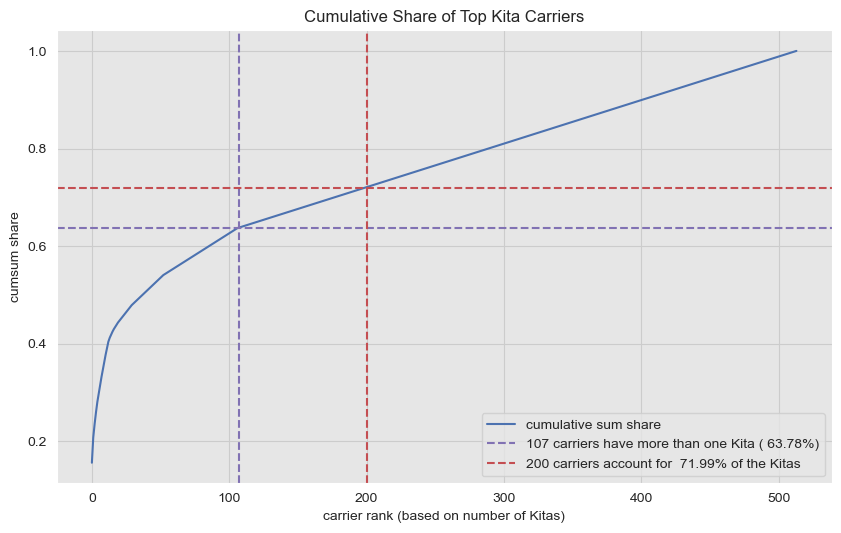

In [44]:
k = 200 
k_cumsum_share = carrier_df.query(f'idx == {k - 1}')['cumsum_share'].values[0]
idx_single_kita = carrier_df.query('single_kita').iloc[0]['idx']
cumsum_share_single_kita = carrier_df.query('single_kita').iloc[0]['cumsum_share']

fig, ax = plt.subplots()
sns.lineplot(x='idx', y='cumsum_share', data=carrier_df, color=sns_c[0], label='cumulative sum share', ax=ax)
ax.axvline(x=idx_single_kita, color=sns_c[4], linestyle='--', label=f'{idx_single_kita} carriers have more than one Kita ({cumsum_share_single_kita: 0.2%})')
ax.axhline(y=cumsum_share_single_kita, color=sns_c[4], linestyle='--')
ax.axvline(x=k, color=sns_c[3], linestyle='--', label=f'{k} carriers account for {k_cumsum_share: 0.2%} of the Kitas')
ax.axhline(y=k_cumsum_share , color=sns_c[3], linestyle='--')
ax.legend(loc='lower right')
ax.set(
    title='Cumulative Share of Top Kita Carriers', 
    xlabel='carrier rank (based on number of Kitas)',
    ylabel='cumsum share'
);

We have two main takeaways from this plot:

1. 107 carriers, which are ~ 20% of the total number of carriers, cover ~ 63% of the number of Kitas.

2. The top 200 carriers, which are ~ 40% of the total number of carriers, cover more than half (~ 72%) of the number of Kitas.

Hence, the carriers. with more than one Kita have a very high coverage.

In [45]:
# We merge the carriers data to. the Kitas data.
kitas_df = pd.merge(
    left=kitas_df, 
    right=carrier_df['single_kita'].reset_index(), 
    on='carrier_name', 
    how='left'
)

Now let us answer the second question by looking into the districts.

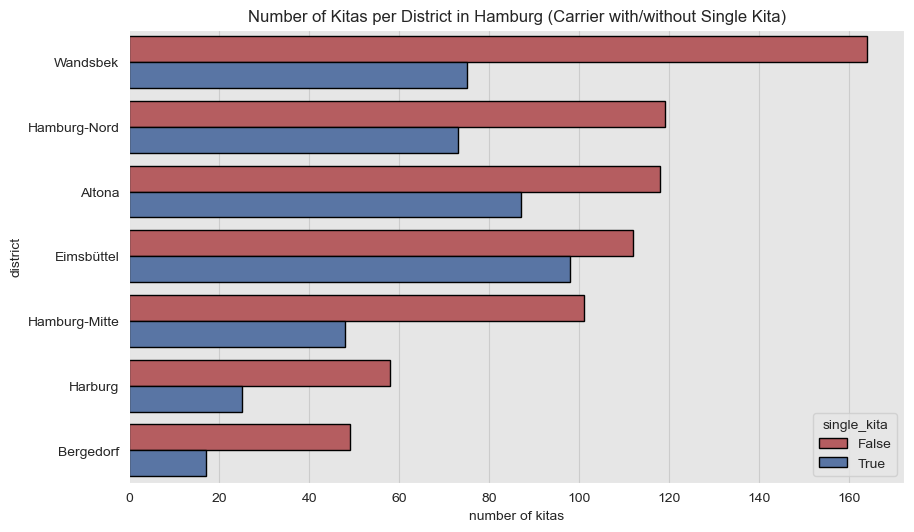

In [46]:
fig, ax = plt.subplots()
kitas_df \
    .groupby(['district', 'single_kita']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='n', 
        y='district',
        hue='single_kita',
        edgecolor='black',
        palette=[sns_c[3], sns_c[0]],
        ax=ax
    )
ax.set(
    title='Number of Kitas per District in Hamburg (Carrier with/without Single Kita)', 
    xlabel='number of kitas', 
    ylabel='district'
);

We can't plot the relative share over districts of number of Kitas and spots.

This ends the an initial exploratory data analysis of the Kitas data. There are still many interesting things to look, but we will leave them for a second iteration.

## Maps & Population Data

Next we enrich out data set by including information about population per plz. In addition, we use maps to visualize some metrics. Please refer to the blog post [Open Data: Germany Maps Viz](https://juanitorduz.github.io/germany_plots/) for the description of the data sources.

Geo-location Data: geo-pandas dataframe with plz geometries.

In [49]:
plz_shape_df = gpd.read_file('data/plz/plz-gebiete.shp', dtype={'plz': str})

plz_shape_df.head()

,plz,note,geometry
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ..."
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ..."
2,52525,"52525 Waldfeucht, Heinsberg","POLYGON ((5.96811 51.05556, 5.96951 51.05660, ..."
3,52074,52074 Aachen,"POLYGON ((5.97486 50.79804, 5.97495 50.79809, ..."
4,52531,52531 Ãbach-Palenberg,"POLYGON ((6.01507 50.94788, 6.03854 50.93561, ..."


+ Population Data

In [50]:
plz_einwohner_df = pd.read_csv(
    'data/plz/plz_einwohner.csv',
    sep=',',
    dtype={'plz': str, 'einwohner': int}
)

plz_einwohner_df.head()

,plz,einwohner
0,01067,11957
1,01069,25491
2,01097,14821
3,01099,28018
4,01108,5876


+ Merge Data

We merge these data sets on plz.

In [51]:
plz_df = pd.merge(
    left=plz_shape_df[['plz', 'geometry']],
    right=plz_einwohner_df,
    on='plz',
    how='left'
)
# Merge with Kitas data.
plz_df = pd.merge(
    left=plz_df,
    right=kitas_df[['district', 'plz', 'num_kitas_plz']].drop_duplicates(),
    on='plz',
    how='inner'
)
# Add features: number of kitas per plz per capita (and its log-transform).
plz_df = plz_df.assign(
    num_kitas_plz_pc = lambda x: x['num_kitas_plz'].div(x['einwohner']), 
    num_kitas_plz_pc_log = lambda x: np.log(x['num_kitas_plz_pc'])
)

plz_df.head()

,plz,geometry,einwohner,district,num_kitas_plz,num_kitas_plz_pc,num_kitas_plz_pc_log
0,22559,"POLYGON ((9.73012 53.55764, 9.73301 53.56270, ...",14638,Altona,10,0.000683,-7.288791
1,22587,"POLYGON ((9.76176 53.57038, 9.77285 53.57073, ...",15583,Altona,8,0.000513,-7.574494
2,21129,"POLYGON ((9.76358 53.50826, 9.76654 53.51414, ...",17415,Hamburg-Mitte,5,0.000287,-8.155649
3,21129,"POLYGON ((9.76358 53.50826, 9.76654 53.51414, ...",17415,Harburg,4,0.000230,-8.378793
4,22589,"POLYGON ((9.77885 53.60228, 9.78131 53.60316, ...",19973,Altona,14,0.000701,-7.263079


First, let us visualize the plz per district in Hamburg (we plot both static and dynamic maps).

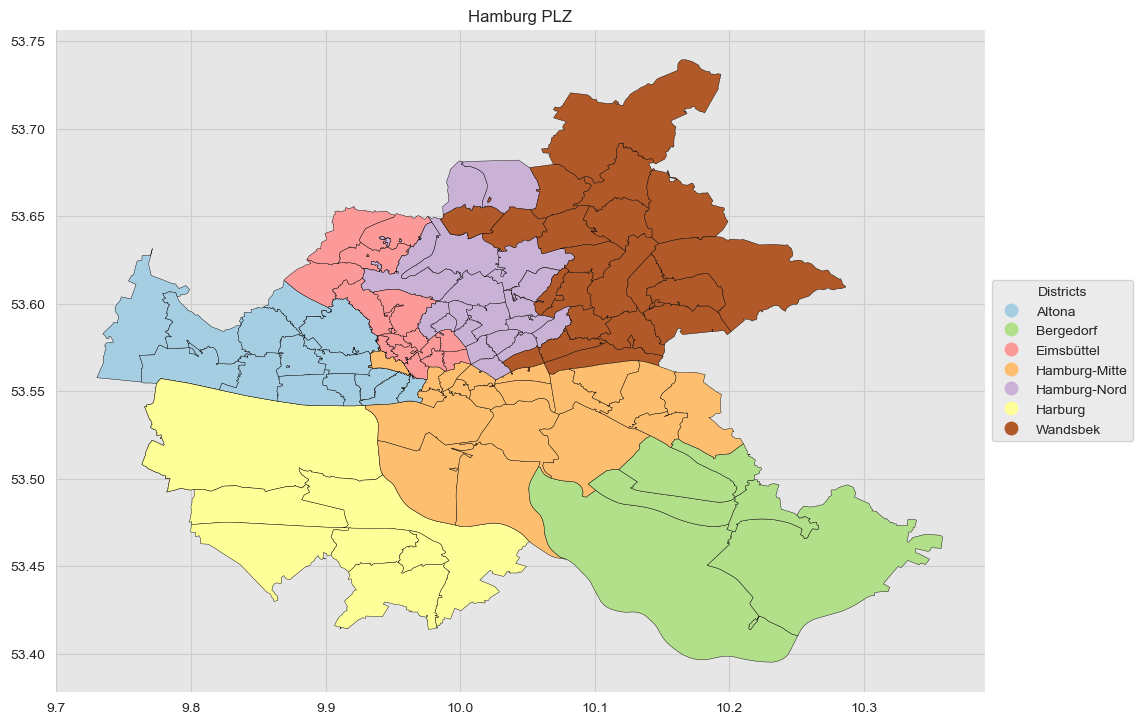

In [52]:
fig, ax = plt.subplots(figsize=(12, 9))
plz_df.plot(
    ax=ax,
    column='district',
    categorical=True,
    cmap='Paired',
    edgecolor='black',
    linewidth=0.3,
    legend=True,
    legend_kwds={'title':'Districts', 'loc': 'center left', 'bbox_to_anchor': (1, 0.5)},
)
ax.set(
    title='Hamburg PLZ',
    aspect=1.3
);

In [ ]:
fig, ax = plt.subplots(figsize=(12, 9))
plz_df.plot(
    ax=ax,
    column='district',
    categorical=True,
    cmap='Paired',
    edgecolor='black',
    linewidth=0.3,
)
mplleaflet.display(fig=fig)

We clearly see that the districts size in area are very close. Note only Eimsbüttel seems a littel smaller.


Next we plot the number if inhabitants per plz.

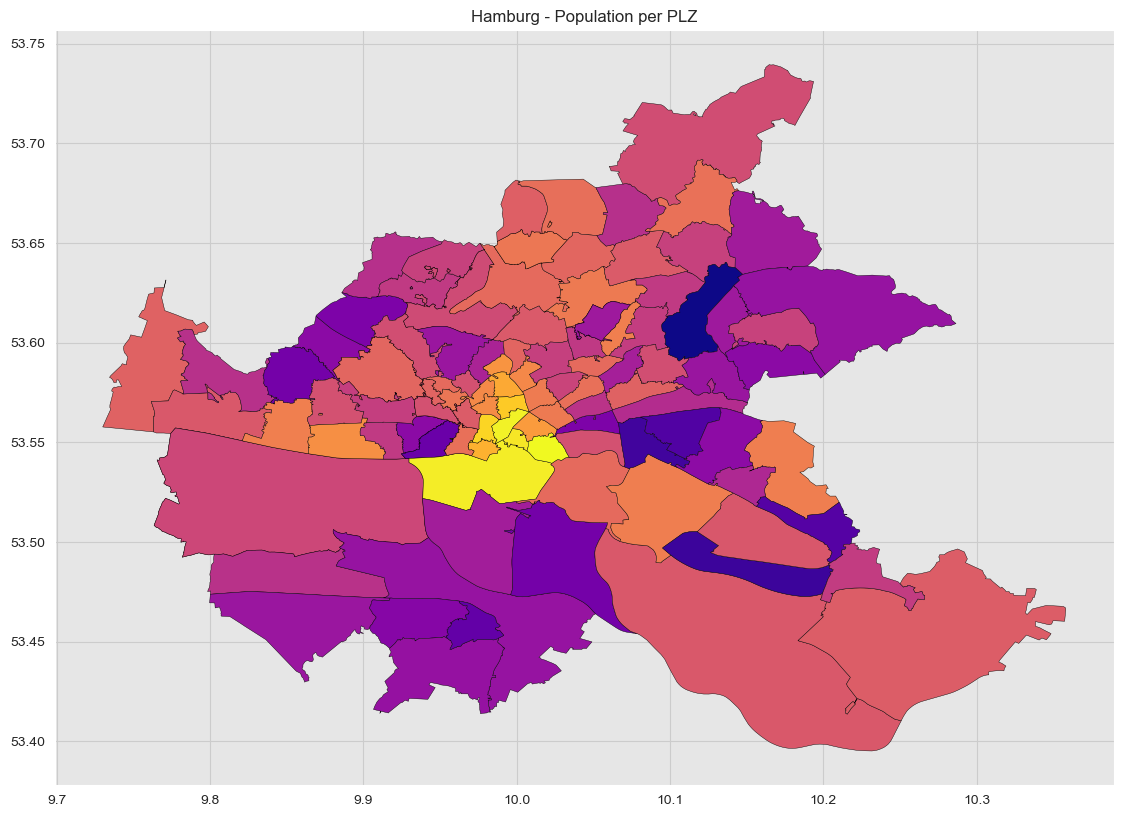

In [55]:
fig, ax = plt.subplots(figsize=(15, 10))
plz_df.plot(
    ax=ax,
    column='einwohner',  
    categorical=False, 
    cmap='plasma_r',
    edgecolor='black',
    linewidth=0.3
)
ax.set(
    title='Hamburg - Population per PLZ',
    aspect=1.3
);

Now we plot the number of Kitas per plz.

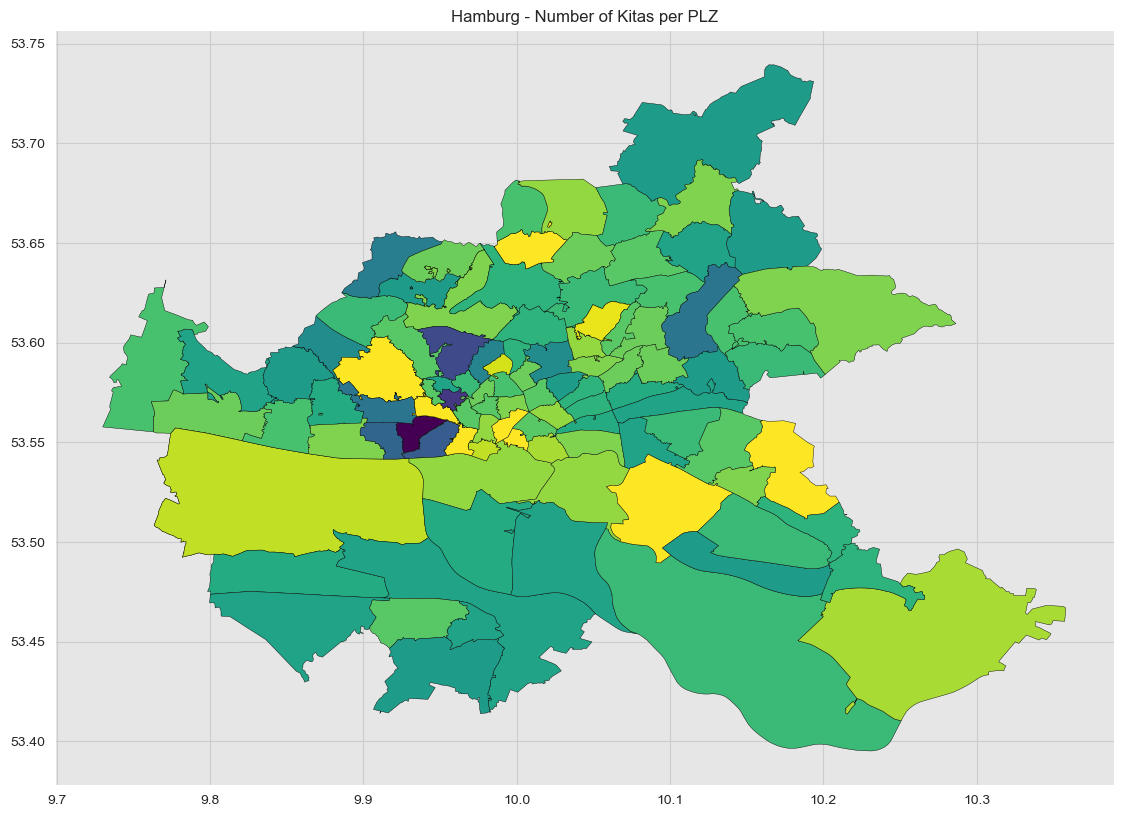

In [56]:
fig, ax = plt.subplots(figsize=(15, 10))
plz_df.plot(
    ax=ax,
    column='num_kitas_plz',
    categorical=False,
    cmap='viridis_r',
    edgecolor='black',
    linewidth=0.3
)
ax.set(
    title='Hamburg - Number of Kitas per PLZ',
    aspect=1.3
);

As we see, comparing plz data without controlling for population can lead to misleading conclusions. Let us not compute the number of Kitas per capita per district.

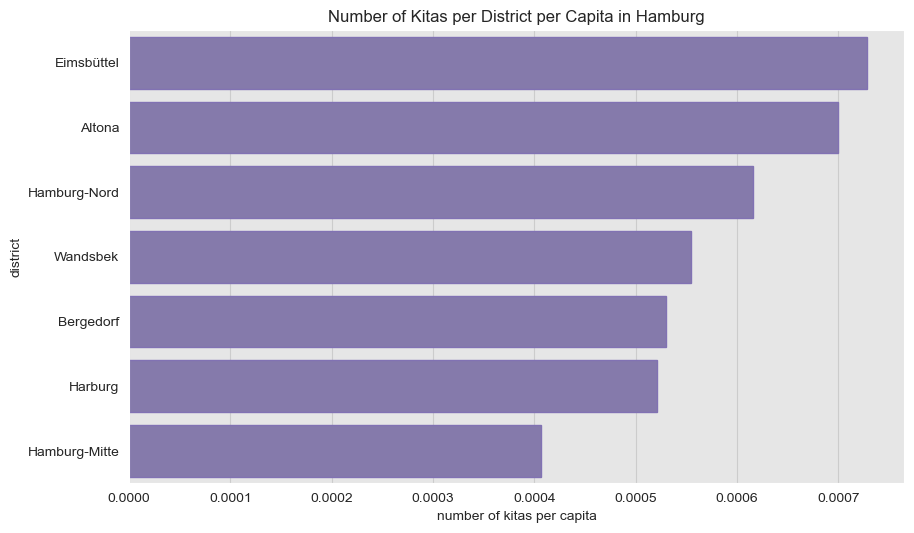

In [57]:
fig, ax = plt.subplots()
plz_df \
    .groupby(['district'], as_index=False) \
    .agg({'einwohner': np.sum, 'num_kitas_plz': np.sum}) \
    .assign(num_kitas_district_pc = lambda x: x['num_kitas_plz'].div(x['einwohner'])) \
    .sort_values('num_kitas_district_pc', ascending=False) \
    .pipe((sns.barplot, 'data'),
        x='num_kitas_district_pc',
        y='district',
        color=sns_c[4],
        edgecolor=sns_c[4],
        ax=ax,
    )
ax.set(
    title='Number of Kitas per District per Capita in Hamburg',
    xlabel='number of kitas per capita',
    ylabel='district',
);

Here we see Eimsbüttel, Altona and Hamburg-Nord are at the top.

Next, we plot the number of Kitas per capita per plz (log-transform).

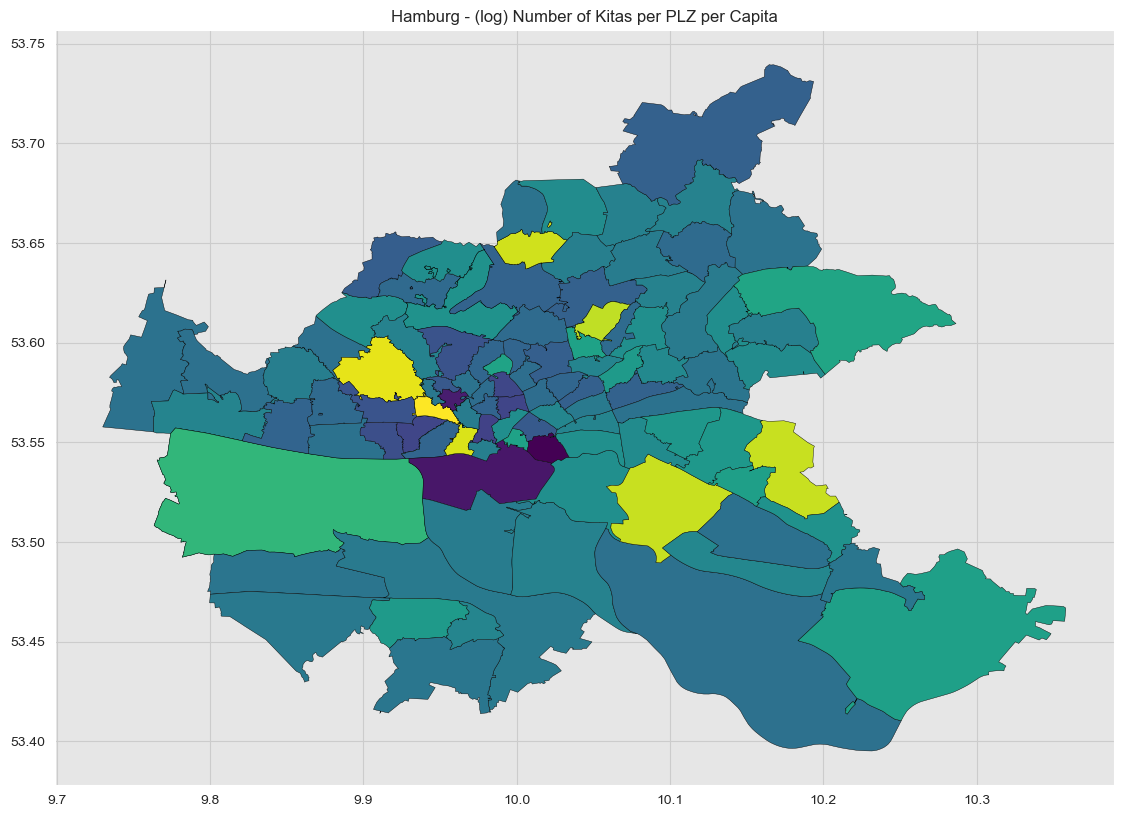

In [58]:
fig, ax = plt.subplots(figsize=(15, 10))
plz_df.plot(
    ax=ax,
    column='num_kitas_plz_pc_log',
    categorical=False,
    cmap='viridis_r',
    edgecolor='black',
    linewidth=0.3
)
ax.set(
    title='Hamburg - (log) Number of Kitas per PLZ per Capita',
    aspect=1.3
);

We immediately see that there is a rather small plz with a high (log) number of Kitas. Let us find which one it is:

In [59]:
plz_df.sort_values('num_kitas_plz_pc', ascending=False).drop('geometry', axis=1).head()


,plz,einwohner,district,num_kitas_plz,num_kitas_plz_pc,num_kitas_plz_pc_log
79,20097,1690,Hamburg-Mitte,5,0.002959,-5.823046
37,20457,2566,Hamburg-Mitte,6,0.002338,-6.058344
46,20259,12541,Eimsbüttel,27,0.002153,-6.140922
58,20355,4381,Hamburg-Mitte,6,0.001370,-6.593273
68,20148,5236,Eimsbüttel,7,0.001337,-6.617403


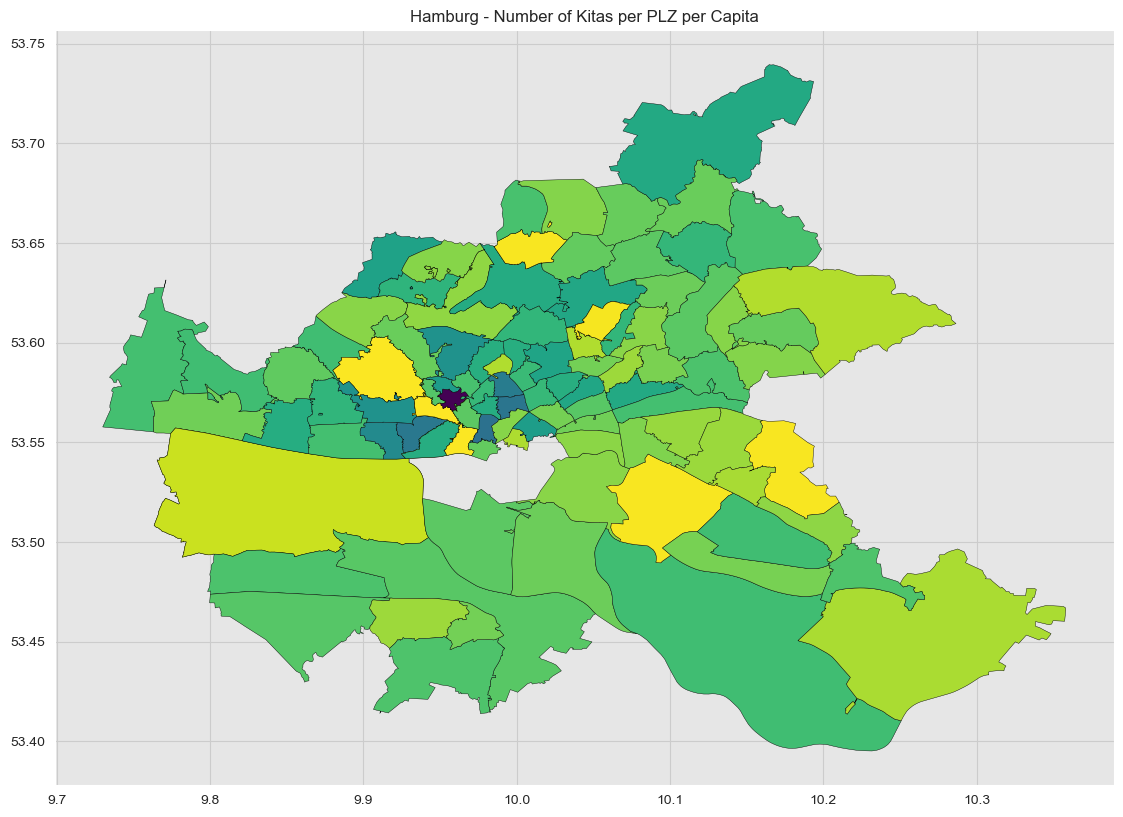

In [61]:
fig, ax = plt.subplots(figsize=(15, 10))
plz_df.query('plz != "20097" and plz != "20457"').plot(
    ax=ax,
    column='num_kitas_plz_pc',
    categorical=False,
    cmap='viridis_r',
    edgecolor='black',
    linewidth=0.3
)
ax.set(
    title='Hamburg - Number of Kitas per PLZ per Capita',
    aspect=1.3
);

## Number of Kitas, Population and Districts Relations

Finally, let us study the relations between number of kitas and population per plz. These variables are naturally correlated:

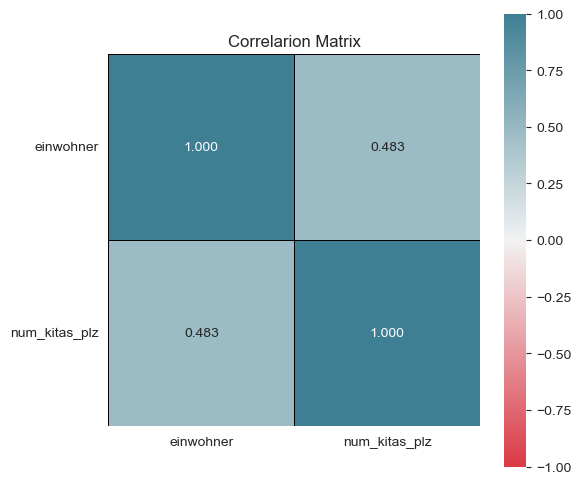

In [62]:
corr_mat = plz_df[['einwohner', 'num_kitas_plz']].corr()
fig, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(
    data=corr_mat, 
    vmin=-1.0, 
    vmax=1.0, 
    center=0, 
    cmap=cmap, 
    square=True,
    linewidths=0.5, 
    linecolor='k',
    annot=True, 
    fmt='.3f',
    ax=ax
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
ax.set_xticklabels(ax.get_yticklabels(), horizontalalignment='center')
ax.set(title='Correlarion Matrix');

We can visualize them in a scatter plot.

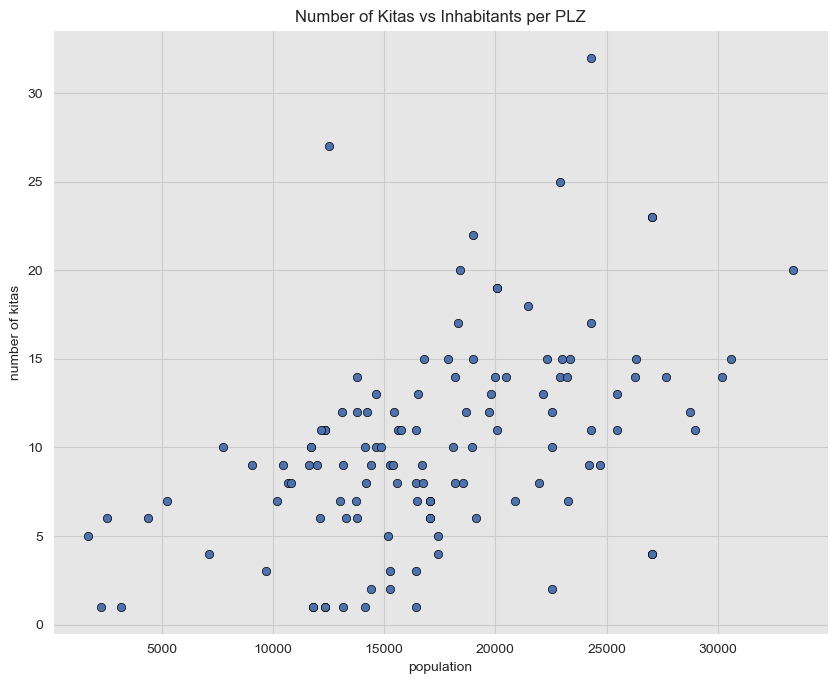

In [66]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(
    x='einwohner',
    y='num_kitas_plz',
    data=plz_df,
#   hue='spots_plz',
    palette='viridis_r',
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)
#ax.legend(**{'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})
ax.set(
    title='Number of Kitas vs Inhabitants per PLZ',
    xlabel='population',
    ylabel='number of kitas'
);

Let us encode the district as color.

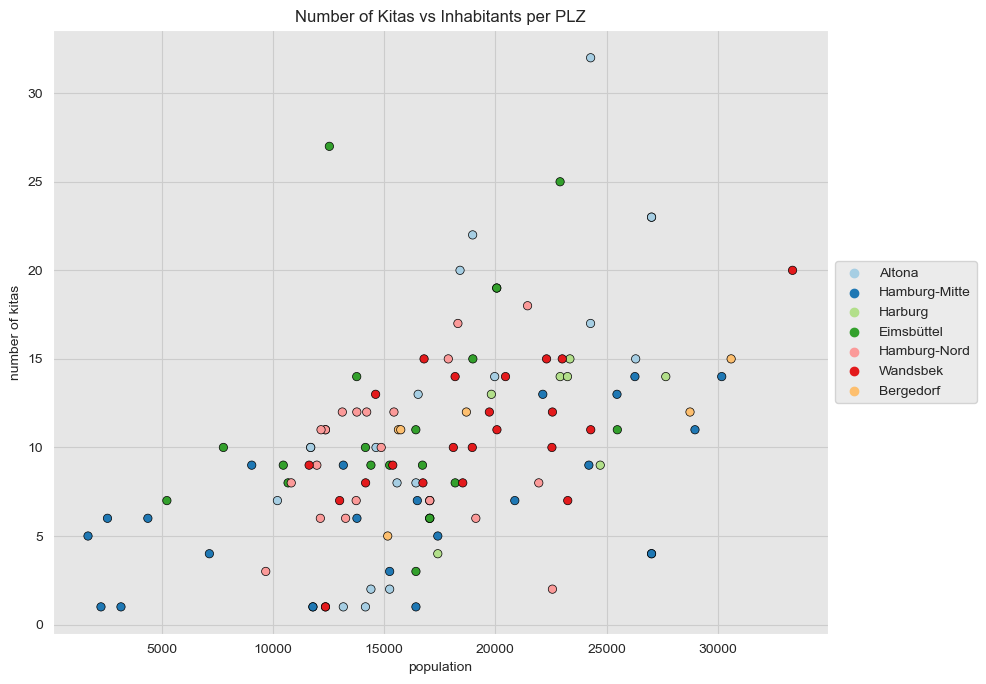

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(
    x='einwohner',
    y='num_kitas_plz',
    data=plz_df,
    hue='district',
    palette='Paired',
    edgecolor='black',
    linewidth=0.5,
#    size='spots_plz',
    ax=ax
)
ax.legend(**{'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})
ax.set(
    title='Number of Kitas vs Inhabitants per PLZ',
    xlabel='population',
    ylabel='number of kitas'
);

Another way to represent their relation is using a 3D-plot.

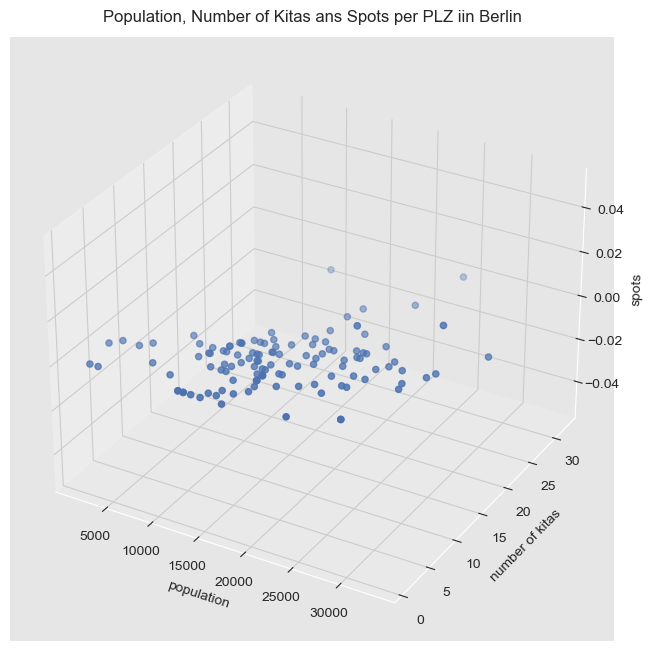

In [67]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import to_hex

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=plz_df['einwohner'], 
    ys=plz_df['num_kitas_plz'], 
#    zs=plz_df['spots_plz'], 
    c=to_hex(sns_c[0])
)
ax.set_title('Population, Number of Kitas ans Spots per PLZ iin Berlin', y=1.1);
ax.set(xlabel='population', ylabel='number of kitas', zlabel='spots');

## Linear Regression Model

A natural question is: *How do the relations above depend on the district?* We of course expect different demographic distributions over different areas of the city. In this first iteration we run a simple linear regression model to estimate the variance explained of `num_kitas_plz` as a linear function of `einwohner` and `district`.

In [69]:
import statsmodels.formula.api as smf

model = smf.ols(formula='num_kitas_plz ~ einwohner + C(district)', data=plz_df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          num_kitas_plz   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     8.233
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           4.09e-08
Time:                        05:53:47   Log-Likelihood:                -363.72
No. Observations:                 123   AIC:                             743.4
Df Residuals:                     115   BIC:                             765.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

We now look into the model predictions.

In [70]:
# Collect predictions.
plz_model_df = pd.concat([plz_df, result.get_prediction(plz_df).summary_frame()], axis=1)
# Compute errors.
plz_model_df = plz_model_df.assign(error = lambda x: x['mean'] - x['num_kitas_plz'])

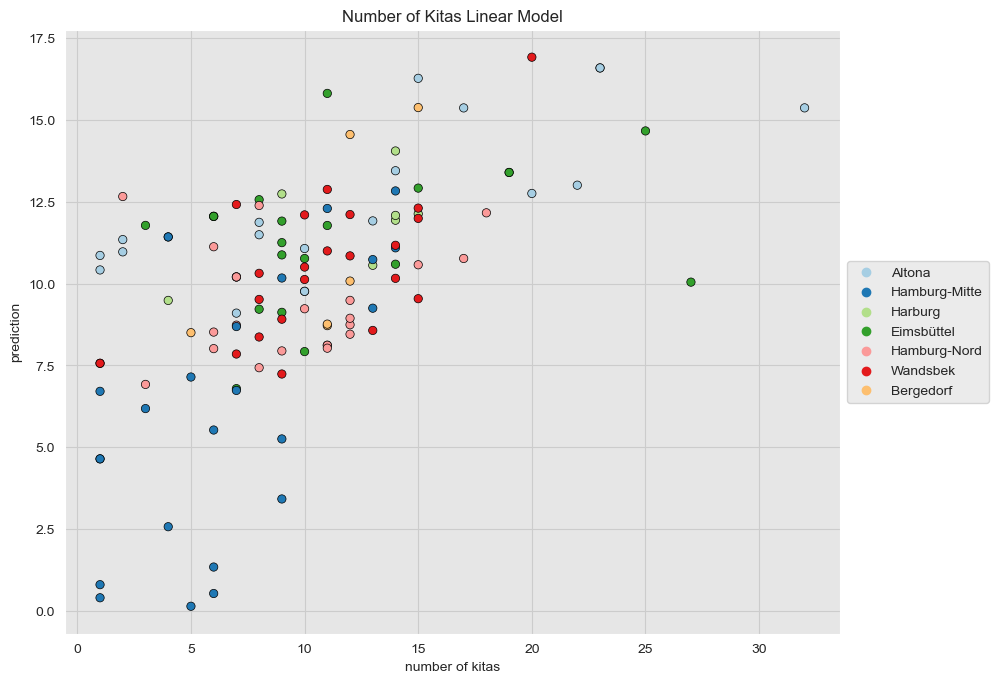

In [72]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(
    x='num_kitas_plz',
    y='mean',
    data=plz_model_df,
    hue='district',
    palette='Paired',
    edgecolor='black',
    linewidth=0.5,
#    size='spots_plz',
    ax=ax
)
ax.legend(**{'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})
ax.set(
    title='Number of Kitas Linear Model',
    xlabel='number of kitas',
    ylabel='prediction'
);

Finally, we plot the errors distribution:

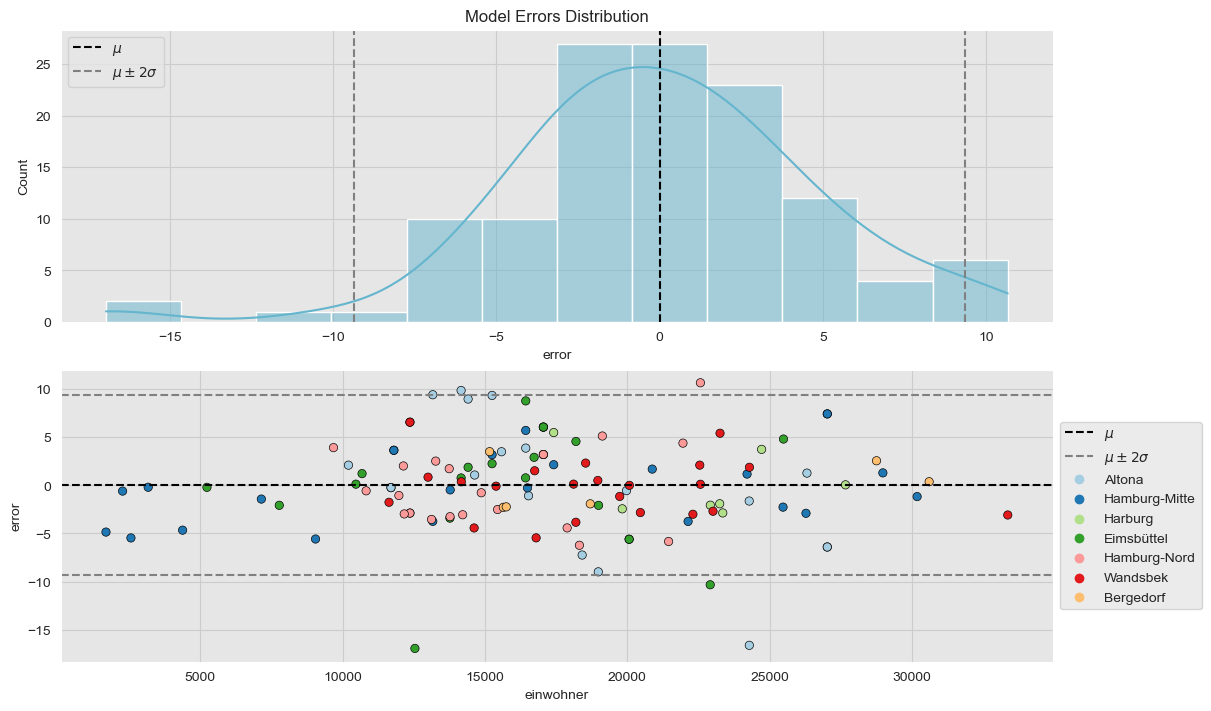

In [74]:
error_mean = plz_model_df['error'].mean()
error_std = plz_model_df['error'].std()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), constrained_layout=True)
sns.histplot(x='error', data=plz_model_df, color=sns_c[9], kde=True, ax=ax[0])
ax[0].axvline(x=error_mean, color='black', linestyle='--', label=f'$\mu$')
ax[0].axvline(x=error_mean + 2*error_std, color='gray', linestyle='--', label=f'$\mu\pm2\sigma$')
ax[0].axvline(x=error_mean - 2*error_std, color='gray', linestyle='--')
sns.scatterplot(x='einwohner', y='error', data=plz_model_df, hue='district', palette='Paired', edgecolor='black', ax=ax[1])
ax[1].axhline(y=error_mean, color='black', linestyle='--', label=f'$\mu$')
ax[1].axhline(y=error_mean + 2*error_std, color='gray', linestyle='--', label=f'$\mu\pm2\sigma$')
ax[1].axhline(y=error_mean - 2*error_std, color='gray', linestyle='--')
ax[0].legend()
ax[1].legend(**{'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})
ax[0].set(title='Model Errors Distribution');

The model is not perfect, but is a good place to start for a deeper analysis: ideally more data about the district demographics will be added and Bayesian methods like the ones presented in [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) by Richard McElreath.